# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pandas as pd
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, concat, count, desc, asc, explode, lit, split, stddev, udf, isnan, when, rank, from_unixtime

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Capstone") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')

In [4]:
for _ in df:
    print(_)

Column<b'artist'>
Column<b'auth'>
Column<b'firstName'>
Column<b'gender'>
Column<b'itemInSession'>
Column<b'lastName'>
Column<b'length'>
Column<b'level'>
Column<b'location'>
Column<b'method'>
Column<b'page'>
Column<b'registration'>
Column<b'sessionId'>
Column<b'song'>
Column<b'status'>
Column<b'ts'>
Column<b'userAgent'>
Column<b'userId'>


In [5]:
def count_missing(df, col):
    """
    A helper function which count how many missing values in a colum of the dataset.
    
    This function is useful because the data can be either three cases below:
    
    1. NaN
    2. Null
    3. "" (empty string)
    """
    return df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "")).count()

In [6]:
print("[missing values]\n")
for col in df.columns:
    missing_count = count_missing(df, col)
    if missing_count > 0:
        print("{}: {}".format(col, missing_count))

[missing values]

artist: 58392
firstName: 8346
gender: 8346
lastName: 8346
length: 58392
location: 8346
registration: 8346
song: 58392
userAgent: 8346
userId: 8346


In [7]:
df_cleaned = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_cleaned = df_cleaned.filter(df["userId"] != "")

In [8]:
print("df:                    {}".format(df.count()))
print("df_without_missing_id: {}".format(df_cleaned.count())) # no missing values

if df.count() == df_cleaned.count():
    print("No missing values with userId and sessionId")
else:
    print("{} rows have been removed.".format(df.count() - df_cleaned.count()))

df:                    286500
df_without_missing_id: 278154
8346 rows have been removed.


In [9]:
df = df_cleaned

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
df.select("*").show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [11]:
df_describe = df.describe().toPandas()

In [12]:
df_describe.head()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,278154,278154,278154,278154,278154,228108,278154,278154,278154,278154,278154,278154,228108,278154,278154,278154,278154
1,mean,551.0852017937219,None,None,None,114.89918174824018,None,249.11718197783722,None,None,None,None,1.535358834085557E12,1042.5616241362698,Infinity,209.10321620397335,1.5409589154318577E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.85172939949013,None,99.23517921058324,None,None,None,None,3.291321616328068E9,726.5010362219821,NaN,30.151388851327823,1.5068287123347573E9,None,109091.94999910519
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",10
4,max,ÃÂlafur Arnalds,Logged In,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [13]:
df.select('itemInSession').dropDuplicates().show()

+-------------+
|itemInSession|
+-------------+
|           26|
|           29|
|          474|
|          964|
|           65|
|          191|
|          418|
|          541|
|          558|
|         1010|
|         1224|
|         1258|
|         1277|
|          222|
|          270|
|          293|
|          730|
|          938|
|         1127|
|         1145|
+-------------+
only showing top 20 rows



In [14]:
df.describe('page').show()

+-------+-------+
|summary|   page|
+-------+-------+
|  count| 278154|
|   mean|   null|
| stddev|   null|
|    min|  About|
|    max|Upgrade|
+-------+-------+



In [15]:
df.describe('status').show()

+-------+------------------+
|summary|            status|
+-------+------------------+
|  count|            278154|
|   mean|209.10321620397335|
| stddev|30.151388851327823|
|    min|               200|
|    max|               404|
+-------+------------------+



In [16]:
df.describe('method').show()

+-------+------+
|summary|method|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|   GET|
|    max|   PUT|
+-------+------+



In [17]:
df.describe('level').show()

+-------+------+
|summary| level|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|  free|
|    max|  paid|
+-------+------+



In [18]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [19]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType

In [20]:
flag_churned_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_churned = df.withColumn("churned", flag_churned_event("page"))

In [21]:
df_churned.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'churned']

In [22]:
churned_rate = df_churned.groupby("userId").agg({"churned": "sum"}).select(avg("sum(churned)")).collect()[0]["avg(sum(churned))"]
print("churned: {:.2f}%".format(churned_rate * 100))

churned: 23.11%


In [23]:
df_churned.select(["userId", "gender", "level", "page", "status", "ts", "churned"]).show(30)

+------+------+-----+---------------+------+-------------+-------+
|userId|gender|level|           page|status|           ts|churned|
+------+------+-----+---------------+------+-------------+-------+
|    30|     M| paid|       NextSong|   200|1538352117000|      0|
|     9|     M| free|       NextSong|   200|1538352180000|      0|
|    30|     M| paid|       NextSong|   200|1538352394000|      0|
|     9|     M| free|       NextSong|   200|1538352416000|      0|
|    30|     M| paid|       NextSong|   200|1538352676000|      0|
|     9|     M| free|       NextSong|   200|1538352678000|      0|
|     9|     M| free|       NextSong|   200|1538352886000|      0|
|    30|     M| paid|       NextSong|   200|1538352899000|      0|
|    30|     M| paid|Add to Playlist|   200|1538352905000|      0|
|    30|     M| paid|       NextSong|   200|1538353084000|      0|
|     9|     M| free|       NextSong|   200|1538353146000|      0|
|     9|     M| free|    Roll Advert|   200|1538353150000|    

In [24]:
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax

In [25]:
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df_phase = df_churned.withColumn("phase", Fsum('churned').over(windowval))
df_churn = df_phase.withColumn("churn", Fmax('churned').over(Window.partitionBy("userId")))

In [26]:
df_churn.select(["userId", "gender", "level", "page", "status", "ts", "churned", "phase", "churn"]).show(20)

+------+------+-----+-----------+------+-------------+-------+-----+-----+
|userId|gender|level|       page|status|           ts|churned|phase|churn|
+------+------+-----+-----------+------+-------------+-------+-----+-----+
|100010|     F| free|   NextSong|   200|1539003534000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539003736000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539003932000|      0|    0|    0|
|100010|     F| free|  Thumbs Up|   307|1539003933000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004195000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004511000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004694000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004918000|      0|    0|    0|
|100010|     F| free|Roll Advert|   200|1539004961000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539005157000|      0|    0|    0|
|100010|     F| free|   N

In [27]:
df_churn.filter(df_churn["churn"] == 1).select(["userId", "gender", "level", "page", "status", "ts", "churned", "phase", "churn"]).show()

+------+------+-----+--------------------+------+-------------+-------+-----+-----+
|userId|gender|level|                page|status|           ts|churned|phase|churn|
+------+------+-----+--------------------+------+-------------+-------+-----+-----+
|   125|     M| free|            NextSong|   200|1539317144000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539317481000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539317711000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539317914000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318124000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318515000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318728000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318906000|      0|    0|    1|
|   125|     M| free|         Roll Advert|   200|1539318917000|      0|    0

In [28]:
churned_user_count = df_churn.filter(df_churn["churn"] == 1).select("userId").dropDuplicates().count()
print("churned user count: {} (total: {})".format(churned_user_count, df_churn.count()))
print("churned user rate: {:.2f}%".format(churned_user_count / df_churn.count() * 100))

churned user count: 52 (total: 278154)
churned user rate: 0.02%


In [29]:
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

In [30]:
df_churn_user = df_churn.groupby("userId").max("churn").withColumnRenamed("max(churn)", "churn").select(["userId", "churn"])

In [31]:
pd_gender = df_churn.select(["userId", "gender", "churn"]).withColumn("churn", func_churn_label("churn")).toPandas()
pd_gender.head()

,userId,gender,churn
0,100010,F,Not Churn
1,100010,F,Not Churn
2,100010,F,Not Churn
3,100010,F,Not Churn
4,100010,F,Not Churn


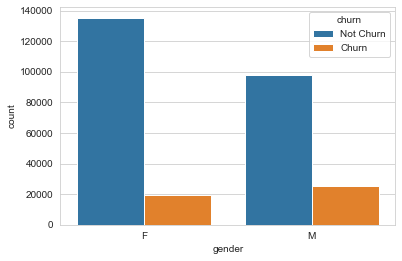

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes("pastel")
sns.set_style("whitegrid")
%matplotlib inline
sns.countplot(x="gender", hue="churn", data=pd_gender);

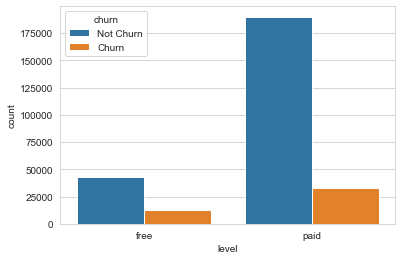

In [33]:
pd_level = df_churn.select(["userId", "level", "churn"]).withColumn("churn", func_churn_label("churn")).toPandas()
pd_level.head()
sns.countplot(x="level", hue="churn", data=pd_level);

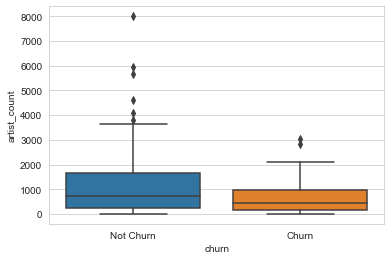

In [34]:
pd_artist = df_churn_user.join(df_churn.groupby("userId") \
                                    .agg({"artist": "count"}) \
                                    .withColumnRenamed("count(artist)", "artist_count"), ["userId"]) \
                         .withColumn("churn", func_churn_label("churn")).toPandas()
pd_artist.head()
sns.boxplot(x="churn", y="artist_count", data=pd_artist);

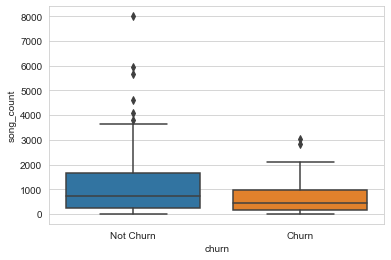

In [35]:
pd_song = df_churn_user.join(df_churn.groupby("userId") \
                                     .agg({"song": "count"}) \
                                     .withColumnRenamed("count(song)", "song_count"), ["userId"]) \
                       .withColumn("churn", func_churn_label("churn")).toPandas()
pd_song.head()
sns.boxplot(x="churn", y="song_count", data=pd_song);

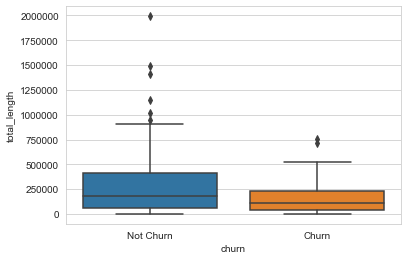

In [36]:
pd_length = df_churn_user.join(df_churn.groupby("userId") \
                                       .agg({"length": "sum"}) \
                                       .withColumnRenamed("sum(length)", "total_length"), ["userId"]) \
                          .withColumn("churn", func_churn_label("churn")).toPandas()
pd_length.head()
sns.boxplot(x="churn", y="total_length", data=pd_length);

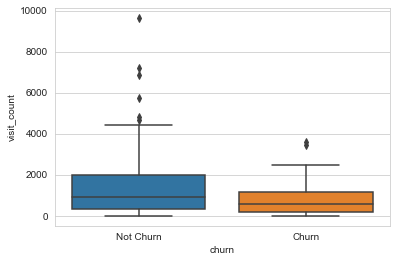

In [37]:
pd_visit = df_churn_user.join(df_churn.groupby("userId") \
                                      .count() \
                                      .withColumnRenamed("count", "visit_count"), ["userId"]) \
                         .withColumn("churn", func_churn_label("churn")).toPandas()
pd_visit.head()
sns.boxplot(x="churn", y="visit_count", data=pd_visit);

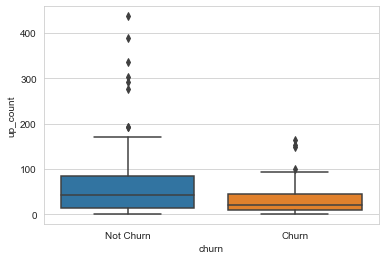

In [38]:
pd_up = df_churn_user.join(df_churn.filter((df_churn["page"] == 'Thumbs Up')) \
                                   .groupby("userId") \
                                   .count() \
                                   .withColumnRenamed("count", "up_count"), ["userId"]) \
                     .withColumn("churn", func_churn_label("churn")).toPandas()
pd_up.head()
sns.boxplot(x="churn", y="up_count", data=pd_up);

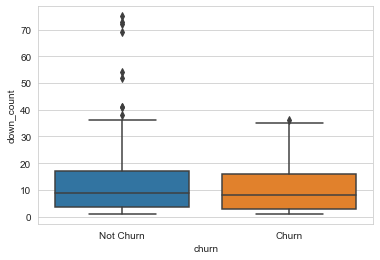

In [39]:
pd_down = df_churn_user.join(df_churn.filter((df_churn["page"] == 'Thumbs Down')) \
                                   .groupby("userId") \
                                   .count() \
                                   .withColumnRenamed("count", "down_count"), ["userId"]) \
                     .withColumn("churn", func_churn_label("churn")).toPandas()
pd_down.head()
sns.boxplot(x="churn", y="down_count", data=pd_down);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [40]:
df_original = df_churn.groupby('userId').max("churn").withColumnRenamed("max(churn)", "target")
user_artist = df_churn.groupby("userId").agg({"artist": "count"}).withColumnRenamed("count(artist)", "artist_count")
flag_gender = udf(lambda x: 1 if x == "F" else 0, IntegerType())
df_churn_with_gender = df_churn.withColumn("gender", flag_gender("gender"))
user_gender = df_churn_with_gender.groupby('userId').agg({"gender": "max"}).withColumnRenamed("max(gender)", "gender")
user_length = df_churn.groupby('userId').agg({"length": "sum"}).withColumnRenamed("sum(length)", "length")
user_thumbs_up = df_churn.filter(df_churn["page"] == 'Thumbs Up').groupby('userId').count().withColumnRenamed("count", "thumb_up")
user_thumbs_down = df_churn.filter(df_churn["page"] == 'Thumbs Down').groupby('userId').count().withColumnRenamed("count", "thumb_down")
flag_level = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
df_churn_with_level = df_churn.withColumn("level", flag_level("level"))
user_level = df_churn_with_level.groupby('userId').agg({"level": "max"}).withColumnRenamed("max(level)", "level")
user_song = df_churn.groupby("userId").agg({"song": "count"}).withColumnRenamed("count(song)", "song_count")

In [41]:
merged_df = df_original.join(user_artist, ['userId']) \
    .join(user_gender, ['userId']) \
    .join(user_length, ['userId']) \
    .join(user_level, ['userId']) \
    .join(user_thumbs_up, ['userId']) \
    .join(user_thumbs_down, ['userId']) \
    .join(user_song, ['userId'])

In [42]:
merged_df.show(5)

+------+------+------------+------+------------------+-----+--------+----------+----------+
|userId|target|artist_count|gender|            length|level|thumb_up|thumb_down|song_count|
+------+------+------------+------+------------------+-----+--------+----------+----------+
|100010|     0|         275|     1|       66940.89735|    0|      17|         5|       275|
|200002|     0|         387|     0| 94008.87593999993|    1|      21|         6|       387|
|   124|     0|        4079|     1|1012312.0927899999|    1|     171|        41|      4079|
|    51|     1|        2111|     0| 523275.8428000001|    1|     100|        21|      2111|
|     7|     0|         150|     0|        38034.0871|    0|       7|         1|       150|
+------+------+------------+------+------------------+-----+--------+----------+----------+
only showing top 5 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [43]:
merged_df_without_user = merged_df.drop("userId")
feature_columns = [col for col in merged_df_without_user.columns if col!='target']
feature_columns

['artist_count',
 'gender',
 'length',
 'level',
 'thumb_up',
 'thumb_down',
 'song_count']

In [44]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [45]:
train, test = merged_df_without_user.randomSplit([0.7, 0.3], seed=0)

In [46]:
def build_model(classifier, param):
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='target', metricName='f1'),
        numFolds=5,
    )
    return model

**Logistic Regression**

In [47]:
lr = LogisticRegression(featuresCol="scaled_features", labelCol="target")
param = ParamGridBuilder().build()
model = build_model(lr, param)

In [48]:
%%time
fit_model = model.fit(train)

Wall time: 37min 23s


In [49]:
pred = fit_model.transform(test)

In [50]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target")

In [51]:
f1_score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
print("f1: {}".format(f1_score))

f1: 0.7324641460234681


**Random Forest**

In [52]:
%%time
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="target")
rf_param = ParamGridBuilder().build()
rf_model = build_model(rf, rf_param)
rf_fit_model = rf_model.fit(train)
rf_pred = rf_fit_model.transform(test)
rf_pred.select("prediction").dropDuplicates().collect()

rf_f1_score = evaluator.evaluate(rf_pred, {evaluator.metricName: "f1"})
print("f1: {}".format(rf_f1_score))

f1: 0.716976127320955
Wall time: 52min 48s


**Feature Evaluation**

In [53]:
rf_feature_importance_df = pd.DataFrame()
rf_feature_importance_df['feature'] = feature_columns
rf_feature_importance_df['importance'] = rf_fit_model.bestModel.stages[2].featureImportances.values.tolist()
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
rf_feature_importance_df

,feature,importance
0,thumb_down,0.242458
1,artist_count,0.220867
2,thumb_up,0.201844
3,song_count,0.156758
4,length,0.088738
5,gender,0.056059
6,level,0.033277


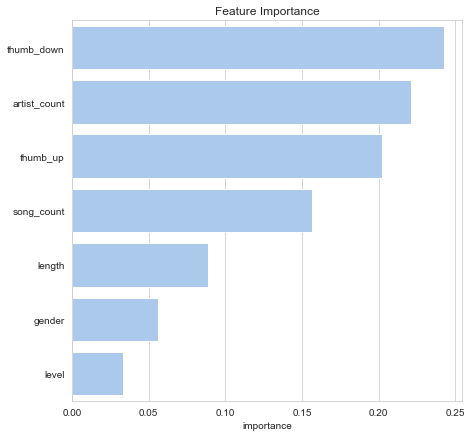

In [54]:
plt.figure(figsize=(7,7))
sns.barplot(x='importance', y='feature', data=rf_feature_importance_df, color="b")
plt.title('Feature Importance')
plt.ylabel('');

**HyperTuning**

In [55]:
classifier = RandomForestClassifier(featuresCol="scaled_features", labelCol="target")

param_grid = ParamGridBuilder() \
    .addGrid(classifier.maxDepth,[5, 10]) \
    .addGrid(classifier.numTrees, [20, 50]) \
    .addGrid(classifier.minInstancesPerNode, [1, 10]) \
    .build()

model_tuned = build_model(classifier, param_grid)

In [56]:
%%time
fit_model_tuned = model_tuned.fit(train)

Wall time: 1h 33min 8s


In [58]:
best_model = fit_model_tuned.bestModel

In [59]:
best_model_pred = best_model.transform(test)

In [60]:
best_model_pred.show(5)

+------+------------+------+------------------+-----+--------+----------+----------+--------------------+--------------------+--------------------+--------------------+----------+
|target|artist_count|gender|            length|level|thumb_up|thumb_down|song_count|            features|     scaled_features|       rawPrediction|         probability|prediction|
+------+------------+------+------------------+-----+--------+----------+----------+--------------------+--------------------+--------------------+--------------------+----------+
|     0|         275|     1|       66940.89735|    0|      17|         5|       275|[275.0,1.0,66940....|[0.04206791687785...|[13.7983650069223...|[0.68991825034611...|       0.0|
|     0|        1914|     0|477307.60580999975|    1|      81|        14|      1914|[1914.0,0.0,47730...|[0.31897279945936...|[15.5101082941487...|[0.77550541470743...|       0.0|
|     0|        1928|     1| 483118.9038399998|    1|      96|        17|      1928|[1928.0,1.0,4831

In [61]:
best_f1_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "f1"})
print("f1: {}".format(best_f1_score))

f1: 0.716976127320955


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.